# Image Acquisition

In [1]:
#importing all the required dependencies

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\Shubam Sachdeva\AppData\Local\Continuum\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#training the model to detect skin

#this function reads in the data from Skin_NonSKin.txt
def ReadData():
    #Data in format [B G R Label]
    data = np.genfromtxt('Skin_NonSkin.txt', dtype=np.int32)

    labels= data[:,3]
    data= data[:,0:3]

    return data, labels

#converts BGR image to HSV 
def BGR2HSV(bgr):
    bgr= np.reshape(bgr,(bgr.shape[0],1,3))
    hsv= cv2.cvtColor(np.uint8(bgr), cv2.COLOR_BGR2HSV)
    hsv= np.reshape(hsv,(hsv.shape[0],3))

    return hsv

#training decision tree classifier for skin detection
def TrainTree(data, labels, flUseHSVColorspace):
    
    if(flUseHSVColorspace):
        data= BGR2HSV(data)
        print("For HSV classifier :")
        print("")
    else :
        data= BGR2HSV(data)
        print("For RGB classifier :")
        print("")
    
    trainData, testData, trainLabels, testLabels = train_test_split(data, labels, test_size=0.20, random_state=42)

    print("There are {} data points for training the skin detection classifier".format(trainData.shape[0]))
    print("There are {} data points for testing the skin detection classifier".format(testData.shape[0]))

    clf = tree.DecisionTreeClassifier(criterion='entropy')
    clf = clf.fit(trainData, trainLabels)
    #print(clf.feature_importances_)
    print("Accuracy on testing data : {}".format(clf.score(testData, testLabels)))

    return clf


#training both the classifiers : classifier for BGR and for HSV values
data, labels= ReadData()
print("")
clf_HSV = TrainTree(data, labels, True)
print("")
print("")
clf_RGB = TrainTree(data, labels, False)


For HSV classifier :

There are 196045 data points for training the skin detection classifier
There are 49012 data points for testing the skin detection classifier
Accuracy on testing data : 0.9995307271688566


For RGB classifier :

There are 196045 data points for training the skin detection classifier
There are 49012 data points for testing the skin detection classifier
Accuracy on testing data : 0.9995103240022851


I have decided to use a decision tree classifer beacuse it works without any delay. Its very time consuming to train and run the model for CNN but for decision tree, the process is realtime as you could possibly test.  For the purpose of face detection in real time, face cascade is used. cascades are used in opencv. It is a library for computer vision. The reason for choosing haar cascades over CNN to recognize face is because they are very accurate and are realtime.

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
#this function removes face from the picture. It takes in an RGB image as input.
#The parameter img is the image.
#The other paramter takes in a boolean value. True uses the HSV classifier while False uses RGB classifier.
#Since both the classifiers return the same accuracy, any of them can be used.
#however, in real time it is seen that HSV returns good results even when the lightning conditions fluctuate a little
#so, HSV classifier is prefered

def face_removal_image(img, flUseHSVColorspace):
    
    if (flUseHSVColorspace):
        clf = clf_HSV
    else :
        clf = clf_RGB
    
    #img= cv2.imread(path)
    #plt.imshow(img)
    #plt.show()
    #print('orignal image shape: {}'.format(img.shape))
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),-1)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
    
    #plt.imshow(img)
    #plt.show()
    
    return img

In [5]:
#this runs the skin detection classifiers trained above.
#it takes in a RGB image and saves a binary image in the the drive.
#this binary image has no face
#since there are only hands in the image now, the images are perfect to use for CNN.

def skin_detection(img, flUseHSVColorspace):
    
    
    #here, face removal function is called
    img = face_removal_image(img,True)
    
    data= np.reshape(img,(img.shape[0]*img.shape[1],3))
    #print('data shape: {}'.format(data.shape))

    if(flUseHSVColorspace):
        clf = clf_HSV
        data= BGR2HSV(data)
    else :
        clf = clf_RGB

    predictedLabels= clf.predict(data)
    
    #print("Predicted_labels shape : {}".format(predictedLabels.shape))
    
    imgLabels= np.reshape(predictedLabels,(img.shape[0],img.shape[1],1))
    
    #print("Predicted_labels shape : {}".format(imgLabels.shape))
    
    output = ((-(imgLabels-1)+1)*255)
    
    #print("output image shape : {}".format(predictedLabels.shape))
    
    cv2.imwrite('result_temp.png',((-(imgLabels-1)+1)*255))# from [1 2] to [0 255]
    temp_img = cv2.imread('result_temp.png')
    #plt.imshow(temp_img)
    #print("Final image shape : {}".format(temp_img.shape))
    #plt.show()
    
    return temp_img
        

In [12]:
#this function finds the largest contour in the image

def largest_contour(img) :
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    c = max(contours, key = cv2.contourArea)
    x_min=1000
    y_min=1000
    x_max=0
    y_max=0
    for i in range(0,len(c)) :
        x = c[i][0][0]
        if x>x_max :
            x_max = x
        if x<x_min :
            x_min = x
        y = c[i][0][1]
        if y>y_max :
            y_max = y
        if y<y_min :
            y_min = y
    crop_img = img[y_min:y_max, x_min:x_max]
    
    return crop_img

In [7]:
#This function takes in 4 parameters: 
#signer_id,
#the action which is being performed,
#the number of images to be taken
#RGB or HSV classifier


def capture_images(signer_id,action_name,max_images,flUseHSVColorspace) :
    # VideoCapture(0) accepts video stream from the webcam of the computer, the default one
    cap = cv2.VideoCapture(0)
    count = 1
    image_number = 0
    while True :
        _,frame = cap.read()
        count = count+1
        cv2.imshow("frame",frame)
        #the number of frames taken per second is 15. Therefore, every 15th frame is stored so that signer has enough time
        #to switch position or distort theh sign a little, providing the much needed variation in the data
        if count%15 == 0 :
            #remove face from the frames
            img = skin_detection(frame,flUseHSVColorspace)
            img = largest_contour(img)
            action = "images/signer_"+str(signer_id)+"_action_"+str(action_name)+"_take_"+str(image_number)+".jpg"
            cv2.imwrite(action,img)
            saved_img = cv2.read(action)
            saved_img = saved_img.reshape()
            print("image_{} stored".format(image_number))
            print(action)
            count = 0
            image_number = image_number + 1
        if image_number >= max_images :
            break
        k = cv2.waitKey(5) & 0xff
        if k == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

In [112]:
capture_images(1,"a",5,True)

image_0 stored
images/signer_1_action_a_take_0.jpg
image_1 stored
images/signer_1_action_a_take_1.jpg
image_2 stored
images/signer_1_action_a_take_2.jpg
image_3 stored
images/signer_1_action_a_take_3.jpg
image_4 stored
images/signer_1_action_a_take_4.jpg


## Working of the code :

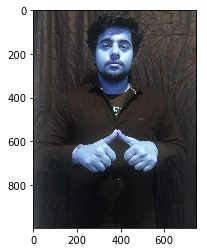

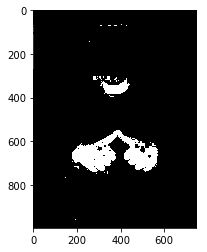

In [10]:
img = cv2.imread("rishab_a.jpg")
plt.imshow(img)
plt.show()
img = skin_detection(img,True)
plt.imshow(img)
plt.show()

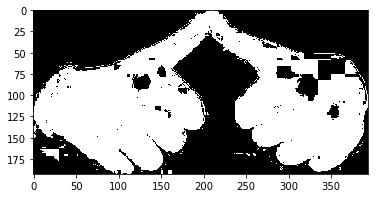

In [13]:
img = largest_contour(img)
plt.imshow(img)
plt.show()